## Simulating Data

In [1]:
import numpy as np
import math
import pandas as pd
from functools import partial
from copy import deepcopy
import os
from scipy.stats import nbinom
from scipy.stats import poisson
from scipy.stats import rv_discrete
from datetime import datetime, date
import matplotlib.pyplot as plt

In [2]:
t1 = date(year = 2011, month= 3, day= 16)
t2 = date(year = 2011, month= 4, day= 15)
t3 = date(year = 2011, month= 5, day= 12)
t4 = date(year = 2011, month= 6, day= 9)
t5 = date(year = 2011, month= 8, day= 19)
t6 = date(year = 2011, month= 9, day= 15)
t7 = date(year = 2011, month= 10, day= 14)
t8 = date(year = 2012, month= 3, day= 20)

In [2]:
def get_rhof(alpha_rho,fmin,freq_nbins=800,freq_dtype='float64'):
    '''
    generates power law (power is alpha_rho) clone frequency distribution over 
    freq_nbins discrete logarithmically spaced frequences between fmin and 1 of dtype freq_dtype
    Outputs log probabilities obtained at log frequencies'''
    fmax=1e0
    logfvec=np.linspace(np.log10(fmin),np.log10(fmax),freq_nbins)
    logfvec=np.array(np.log(np.power(10,logfvec)) ,dtype=freq_dtype).flatten()  
    logrhovec=logfvec*alpha_rho
    integ=np.exp(logrhovec+logfvec,dtype=freq_dtype)
    normconst=np.log(np.dot(np.diff(logfvec)/2.,integ[1:]+integ[:-1]))
    logrhovec-=normconst 
    return logrhovec,logfvec

In [3]:
def get_distsample(pmf,Nsamp,dtype='uint32'):
    '''
    generates Nsamp index samples of dtype (e.g. uint16 handles up to 65535 indices) from discrete probability mass function pmf.
    Handles multi-dimensional domain. N.B. Output is sorted.
    '''
    #assert np.sum(pmf)==1, "cmf not normalized!"
    
    shape = np.shape(pmf)
    sortindex = np.argsort(pmf, axis=None)#uses flattened array
    pmf = pmf.flatten()
    pmf = pmf[sortindex]
    cmf = np.cumsum(pmf)
    choice = np.random.uniform(high = cmf[-1], size = int(float(Nsamp)))
    index = np.searchsorted(cmf, choice)
    index = sortindex[index]
    index = np.unravel_index(index, shape)
    index = np.transpose(np.vstack(index))
    sampled_inds = np.array(index[np.argsort(index[:,0])],dtype=dtype)
    return sampled_inds

In [4]:
def get_nullmodel_sample_observedonly(paras,acq_model_type,NreadsI,NreadsII,Nsamp):
    '''
    outputs an array of observed clone frequencies and corresponding dataframe of pair counts
    for a null model learned from a dataset pair with NreadsI and NreadsII number of reads, respectively.
    Crucial for RAM efficiency, sampling is conditioned on being observed in each of the three (n,0), (0,n'), and n,n'>0 conditions
    so that only Nsamp clones need to be sampled, rather than the N clones in the repertoire.
    Note that no explicit normalization is applied. It is assumed that the values in paras are consistent with N<f>=1 
    (e.g. were obtained through the learning done in this package).
    '''

    
    alpha = paras[0] #power law exponent
    fmin=np.power(10,paras[-1])
    if acq_model_type<2:
        m_total=float(np.power(10, paras[3])) 
        r_c1=NreadsI/m_total
        r_c2=NreadsII/m_total
        r_cvec=[r_c1,r_c2]
    if acq_model_type<3:
        beta_mv= paras[1]
        alpha_mv=paras[2]
    
    logrhofvec,logfvec = get_rhof(alpha,fmin)
    fvec=np.exp(logfvec)
    dlogf=np.diff(logfvec)/2.
    
    #generate measurement model distribution, Pn_f
    Pn_f=np.empty((len(logfvec),),dtype=object) #len(logfvec) samplers
    
    #get value at n=0 to use for conditioning on n>0 (and get full Pn_f here if acq_model_type=2,3)
    m_max=1e3 #conditioned on n=0, so no edge effects
    
    Nreadsvec=(NreadsI,NreadsII)
    for it in range(2):
        Pn_f=np.empty((len(fvec),),dtype=object)
        if acq_model_type==3:
            m1vec=Nreadsvec[it]*fvec
            for find,m1 in enumerate(m1vec):
                Pn_f[find]=poisson(m1)
            logPn0_f=-m1vec
        elif acq_model_type==2:
            m1=Nreadsvec[it]*fvec
            v1=m1+beta_mv*np.power(m1,alpha_mv)
            p=1-m1/v1
            n=m1*m1/v1/p
            for find,(n,p) in enumerate(zip(n,p)):
                Pn_f[find]=nbinom(n,1-p)
            Pn0_f=np.asarray([Pn_find.pmf(0) for Pn_find in Pn_f])
            logPn0_f=np.log(Pn0_f)
        elif acq_model_type==1:
            m1=r_cvec[it]*np.arange(m_max+1)
            v1=m1+beta_mv*np.power(m1,alpha_mv)
            p=1-m1/v1
            p[0]=1.
            n=m1*m1/v1/p
            n[0]=0.
            Pn0_f=np.zeros((len(fvec),))
            for find in range(len(Pn0_f)):
                Pn0_f[find]=np.dot(poisson(m_total*fvec[find]).pmf(np.arange(m_max+1)),np.insert(nbinom(n[1:],1-p[1:]).pmf(0),0,1.))
            logPn0_f=np.log(Pn0_f)
        elif acq_model_type==0:
            m1=m_total*fvec
            v1=m1+beta_mv*np.power(m1,alpha_mv)
            p=1-m1/v1
            n=m1*m1/v1/p
            Pn0_f=np.zeros((len(fvec),))
            for find in range(len(Pn0_f)):
                nbtmp=nbinom(n[find],1-p[find]).pmf(np.arange(m_max+1))
                ptmp=poisson(r_cvec[it]*np.arange(m_max+1)).pmf(0)
                Pn0_f[find]=np.sum(np.exp(np.log(nbtmp)+np.log(ptmp)))
            logPn0_f=np.log(Pn0_f)
        else:
            print('acq_model is 0,1,2, or 3 only')
            
        if it==0:
            Pn1_f=Pn_f
            logPn10_f=logPn0_f
        else:
            Pn2_f=Pn_f
            logPn20_f=logPn0_f

    #3-quadrant q|f conditional distribution (qx0:n1>0,n2=0;q0x:n1=0,n2>0;qxx:n1,n2>0)
    logPqx0_f=np.log(1-np.exp(logPn10_f))+logPn20_f
    logPq0x_f=logPn10_f+np.log(1-np.exp(logPn20_f))
    logPqxx_f=np.log(1-np.exp(logPn10_f))+np.log(1-np.exp(logPn20_f))
    #3-quadrant q,f joint distribution
    logPfqx0=logPqx0_f+logrhofvec
    logPfq0x=logPq0x_f+logrhofvec
    logPfqxx=logPqxx_f+logrhofvec
    #3-quadrant q marginal distribution 
    Pqx0=np.trapz(np.exp(logPfqx0+logfvec),x=logfvec)
    Pq0x=np.trapz(np.exp(logPfq0x+logfvec),x=logfvec)
    Pqxx=np.trapz(np.exp(logPfqxx+logfvec),x=logfvec)
    
    #3 quadrant conditional f|q distribution
    Pf_qx0=np.where(Pqx0>0,np.exp(logPfqx0-np.log(Pqx0)),0)
    Pf_q0x=np.where(Pq0x>0,np.exp(logPfq0x-np.log(Pq0x)),0)
    Pf_qxx=np.where(Pqxx>0,np.exp(logPfqxx-np.log(Pqxx)),0)
    
    #3-quadrant q marginal distribution
    newPqZ=Pqx0 + Pq0x + Pqxx
    Pqx0/=newPqZ
    Pq0x/=newPqZ
    Pqxx/=newPqZ

    Pfqx0=np.exp(logPfqx0)
    Pfq0x=np.exp(logPfq0x)
    Pfqxx=np.exp(logPfqxx)
    
    print('Model probs: '+str(Pqx0)+' '+str(Pq0x)+' '+str(Pqxx))

    #get samples 
    num_samples=Nsamp
    q_samples=np.random.choice(range(3), num_samples, p=(Pqx0,Pq0x,Pqxx))
    vals,counts=np.unique(q_samples,return_counts=True)
    num_qx0=counts[0]
    num_q0x=counts[1]
    num_qxx=counts[2]
    print('q samples: '+str(sum(counts))+' '+str(num_qx0)+' '+str(num_q0x)+' '+str(num_qxx))
    print('q sampled probs: '+str(num_qx0/float(sum(counts)))+' '+str(num_q0x/float(sum(counts)))+' '+str(num_qxx/float(sum(counts))))
    
    #x0
    integ=np.exp(np.log(Pf_qx0)+logfvec)
    f_samples_inds=get_distsample(dlogf*(integ[1:] + integ[:-1]),num_qx0).flatten()
    f_sorted_inds=np.argsort(f_samples_inds)
    f_samples_inds=f_samples_inds[f_sorted_inds] 
    qx0_f_samples=fvec[f_samples_inds]
    find_vals,f_start_ind,f_counts=np.unique(f_samples_inds,return_counts=True,return_index=True)
    qx0_samples=np.zeros((num_qx0,))
    if acq_model_type<2:
        qx0_m_samples=np.zeros((num_qx0,))
        #conditioning on n>0 applies an m-dependent factor to Pm_f, which can't be incorporated into the ppf method used for acq_model_type 2 and 3. 
        #We handle that here by using a custom finite range sampler, which has the drawback of having to define an upper limit. 
        #This works so long as n_max/r_c<<m_max, so depends on highest counts in data (n_max). My data had max counts of 1e3-1e4.
        #Alternatively, could define a custom scipy RV class by defining it's PMF, but has to be array-compatible which requires care. 
        m_samp_max=int(1e5) 
        mvec=np.arange(m_samp_max)   
    
    for it,find in enumerate(find_vals):
        if acq_model_type==0:      
            m1=m_total*fvec[find]
            v1=m1+beta_mv*np.power(m1,alpha_mv)
            p=1-m1/v1
            n=m1*m1/v1/p
            Pm1_f=nbinom(n,1-p)
            
            Pm1_f_adj=np.exp(np.log(1-np.exp(-r_c1*mvec))+np.log(Pm1_f.pmf(mvec))-np.log((1-np.power(np.exp(r_c1+np.log(1-p))/(np.exp(r_c1)-p),n)))) #adds m-dependent factor due to conditioning on n>0...
            Pm1_f_adj_obj=rv_discrete(name='nbinom_adj',values=(mvec,Pm1_f_adj/np.sum(Pm1_f_adj)))
            qx0_m_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pm1_f_adj_obj.rvs(size=f_counts[it])
            
            mvals,minds,m_counts=np.unique(qx0_m_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]],return_inverse=True,return_counts=True)
            for mit,m in enumerate(mvals):
                Pn1_m1=poisson(r_c1*m)
                samples=np.random.random(size=m_counts[mit]) * (1-Pn1_m1.cdf(0)) + Pn1_m1.cdf(0)
                qx0_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]][minds==mit]=Pn1_m1.ppf(samples)
 
        elif acq_model_type==1:
            Pm1_f=poisson(m_total*fvec[find])
            
            m1=r_c1*mvec
            v1=m1+beta_mv*np.power(m1,alpha_mv)
            p=1.-m1/v1
            n=m1*m1/v1/p
            p[0]=1.
            n[0]=0.
            Pn10_m1=nbinom(n,1-p).pmf(0)
            Pn10_m1[0]=1.
            Pm1_f_adj=(1-Pn10_m1)/(1-np.sum(Pm1_f.pmf(mvec)*Pn10_m1))*Pm1_f.pmf(mvec) #adds m-dependent factor due to conditioning on n>0...
            Pm1_f_adj_obj=rv_discrete(name='nbinom_adj',values=(mvec,Pm1_f_adj/np.sum(Pm1_f_adj)))
            qx0_m_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pm1_f_adj_obj.rvs(size=f_counts[it])
            
            mvals,minds,m_counts=np.unique(qx0_m_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]],return_inverse=True,return_counts=True)
            for mit,m in enumerate(mvals):
                m1=r_c1*m
                v1=m1+beta_mv*np.power(m1,alpha_mv)
                if m==0:
                  p=1.
                  n=0.
                else:
                  p=1-m1/v1
                  n=m1*m1/v1/p
                  Pn1_m1=nbinom(n,1-p)
                samples=np.random.random(size=m_counts[mit]) * (1-Pn1_m1.cdf(0)) + Pn1_m1.cdf(0)                        
                qx0_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]][minds==mit]=Pn1_m1.ppf(samples)
        
        elif acq_model_type>1:
            samples=np.random.random(size=f_counts[it]) * (1-Pn1_f[find].cdf(0)) + Pn1_f[find].cdf(0)
            qx0_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pn1_f[find].ppf(samples)
        else:
            print('acq_model is 0,1,2, or 3 only')
    qx0_pair_samples=np.hstack((qx0_samples[:,np.newaxis],np.zeros((num_qx0,1)))) 
    
    #0x
    integ=np.exp(np.log(Pf_q0x)+logfvec)
    f_samples_inds=get_distsample(dlogf*(integ[1:] + integ[:-1]),num_q0x).flatten()
    f_sorted_inds=np.argsort(f_samples_inds)
    f_samples_inds=f_samples_inds[f_sorted_inds] 
    q0x_f_samples=fvec[f_samples_inds]
    find_vals,f_start_ind,f_counts=np.unique(f_samples_inds,return_counts=True,return_index=True)
    q0x_samples=np.zeros((num_q0x,))
    if acq_model_type<2:
        q0x_m_samples=np.zeros((num_q0x,))
    for it,find in enumerate(find_vals):
        if acq_model_type==0:
            m2=m_total*fvec[find]
            v2=m2+beta_mv*np.power(m2,alpha_mv)
            p=1-m2/v2
            n=m2*m2/v2/p
            Pm2_f=nbinom(n,1-p)
            
            Pm2_f_adj=np.exp(np.log(1-np.exp(-r_c2*mvec))+np.log(Pm2_f.pmf(mvec))-np.log((1-np.power(np.exp(r_c2+np.log(1-p))/(np.exp(r_c2)-p),n)))) #adds m-dependent factor due to conditioning on n>0...
            Pm2_f_adj_obj=rv_discrete(name='nbinom_adj',values=(mvec,Pm2_f_adj/np.sum(Pm2_f_adj)))
            q0x_m_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pm2_f_adj_obj.rvs(size=f_counts[it])

            mvals,minds,m_counts=np.unique(q0x_m_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]],return_inverse=True,return_counts=True)
            for mit,m in enumerate(mvals):
                Pn2_m2=poisson(r_c2*m)
                samples=np.random.random(size=m_counts[mit]) * (1-Pn2_m2.cdf(0)) + Pn2_m2.cdf(0)
                q0x_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]][minds==mit]=Pn2_m2.ppf(samples)
        
        elif acq_model_type==1:
            Pm2_f=poisson(m_total*fvec[find])
            
            m2=r_c2*mvec
            v2=m2+beta_mv*np.power(m2,alpha_mv)
            p=1-m2/v2
            n=m2*m2/v2/p
            p[0]=1
            n[0]=0
            Pn20_m2=nbinom(n,1-p).pmf(0)
            Pn20_m2[0]=1.
            Pm2_f_adj=np.exp(np.log(1-Pn20_m2)-np.log(1-np.dot(Pm2_f.pmf(mvec),Pn20_m2))+np.log(Pm2_f.pmf(mvec))) #adds m-dependent factor due to conditioning on n>0...
            Pm2_f_adj_obj=rv_discrete(name='nbinom_adj',values=(mvec,Pm2_f_adj/np.sum(Pm2_f_adj)))
            q0x_m_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pm2_f_adj_obj.rvs(size=f_counts[it])

            mvals,minds,m_counts=np.unique(q0x_m_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]],return_inverse=True,return_counts=True)
            for mit,m in enumerate(mvals):
                m2=r_c2*m
                v2=m2+beta_mv*np.power(m2,alpha_mv)
                if m==0:
                  p=1.
                  n=0.
                else:
                  p=1-m2/v2
                  n=m2*m2/v2/p
                Pn2_m2=nbinom(n,1-p)
                samples=np.random.random(size=m_counts[mit]) * (1-Pn2_m2.cdf(0)) + Pn2_m2.cdf(0)                        
                q0x_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]][minds==mit]=Pn2_m2.ppf(samples)            
        
        elif acq_model_type > 1:
            samples=np.random.random(size=f_counts[it]) * (1-Pn2_f[find].cdf(0)) + Pn2_f[find].cdf(0)
            q0x_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pn2_f[find].ppf(samples)
        else:
            print('acq_model is 0,1,2, or 3 only')
    q0x_pair_samples=np.hstack((np.zeros((num_q0x,1)),q0x_samples[:,np.newaxis]))
    
    #qxx
    integ=np.exp(np.log(Pf_qxx)+logfvec)
    f_samples_inds=get_distsample(dlogf*(integ[1:] + integ[:-1]),num_qxx).flatten()        
    f_sorted_inds=np.argsort(f_samples_inds)
    f_samples_inds=f_samples_inds[f_sorted_inds] 
    qxx_f_samples=fvec[f_samples_inds]
    find_vals,f_start_ind,f_counts=np.unique(f_samples_inds,return_counts=True,return_index=True)
    qxx_n1_samples=np.zeros((num_qxx,))
    qxx_n2_samples=np.zeros((num_qxx,))
    if acq_model_type<2:
        qxx_m1_samples=np.zeros((num_qxx,))
        qxx_m2_samples=np.zeros((num_qxx,))
    for it,find in enumerate(find_vals):
        if acq_model_type==0:
            m1=m_total*fvec[find]
            v1=m1+beta_mv*np.power(m1,alpha_mv)
            p=1-m1/v1
            n=m1*m1/v1/p
            Pm1_f=nbinom(n,1-p)
            
            Pm1_f_adj=np.exp(np.log(1-np.exp(-r_c1*mvec))+np.log(Pm1_f.pmf(mvec))-np.log((1-np.power(np.exp(r_c1+np.log(1-p))/(np.exp(r_c1)-p),n)))) #adds m-dependent factor due to conditioning on n>0...
            if np.sum(Pm1_f_adj)==0:
                qxx_m1_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=1
            else:
                Pm1_f_adj_obj=rv_discrete(name='nbinom_adj',values=(mvec,Pm1_f_adj/np.sum(Pm1_f_adj)))
                qxx_m1_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pm1_f_adj_obj.rvs(size=f_counts[it])

            mvals,minds,m_counts=np.unique(qxx_m1_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]],return_inverse=True,return_counts=True)
            for mit,m in enumerate(mvals):
                Pn1_m1=poisson(r_c1*m)
                samples=np.random.random(size=m_counts[mit]) * (1-Pn1_m1.cdf(0)) + Pn1_m1.cdf(0)
                qxx_n1_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]][minds==mit]=Pn1_m1.ppf(samples)
                
            m2=m_total*fvec[find]
            v2=m2+beta_mv*np.power(m2,alpha_mv)
            p=1-m2/v2
            n=m2*m2/v2/p
            Pm2_f=nbinom(n,1-p)
            
            Pm2_f_adj=np.exp(np.log(1-np.exp(-r_c2*mvec))+np.log(Pm2_f.pmf(mvec))-np.log((1-np.power(np.exp(r_c2+np.log(1-p))/(np.exp(r_c2)-p),n)))) #adds m-dependent factor due to conditioning on n>0...
            if np.sum(Pm1_f_adj)==0:
                qxx_m2_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=1
            else:
                Pm2_f_adj_obj=rv_discrete(name='nbinom_adj',values=(mvec,Pm2_f_adj/np.sum(Pm2_f_adj)))
                qxx_m2_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pm2_f_adj_obj.rvs(size=f_counts[it])

            mvals,minds,m_counts=np.unique(qxx_m2_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]],return_inverse=True,return_counts=True)
            for mit,m in enumerate(mvals):
                Pn2_m2=poisson(r_c2*m)
                samples=np.random.random(size=m_counts[mit]) * (1-Pn2_m2.cdf(0)) + Pn2_m2.cdf(0)
                qxx_n2_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]][minds==mit]=Pn2_m2.ppf(samples)    

        elif acq_model_type==1:
            Pm1_f=poisson(m_total*fvec[find])
            
            m1=r_c1*mvec
            v1=m1+beta_mv*np.power(m1,alpha_mv)
            p=1-m1/v1
            n=m1*m1/v1/p
            p[0]=1
            n[0]=0
            Pn10_m1=nbinom(n,1-p).pmf(0)
            Pn10_m1[0]=1.
            Pm1_f_adj=np.exp(np.log(1-Pn10_m1)-np.log(1-np.dot(Pm1_f.pmf(mvec),Pn10_m1))+np.log(Pm1_f.pmf(mvec))) #adds m-dependent factor due to conditioning on n>0...
            if np.sum(Pm1_f_adj)==0:
                qxx_m1_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=1 #minimum cell size conditional on n>0
            else:
                Pm1_f_adj_obj=rv_discrete(name='nbinom_adj',values=(mvec,Pm1_f_adj/np.sum(Pm1_f_adj)))
                qxx_m1_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pm1_f_adj_obj.rvs(size=f_counts[it])

            mvals,minds,m_counts=np.unique(qxx_m1_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]],return_inverse=True,return_counts=True)
            for mit,m in enumerate(mvals):
                m1=r_c1*m
                v1=m1+beta_mv*np.power(m1,alpha_mv)
                if m==0:
                  p=1.
                  n=0.
                else:
                  p=1-m1/v1
                  n=m1*m1/v1/p
                Pn1_m1=nbinom(n,1-p)
                samples=np.random.random(size=m_counts[mit]) * (1-Pn1_m1.cdf(0)) + Pn1_m1.cdf(0)                        
                qxx_n1_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]][minds==mit]=Pn1_m1.ppf(samples)            
                
            Pm2_f=poisson(m_total*fvec[find])
            
            m2=r_c2*mvec
            v2=m2+beta_mv*np.power(m2,alpha_mv)
            p=1-m2/v2
            n=m2*m2/v2/p
            p[0]=1
            n[0]=0
            Pn20_m2=nbinom(n,1-p).pmf(0)
            Pn20_m2[0]=1.
            Pm2_f_adj=np.exp(np.log(1-Pn20_m2)-np.log(1-np.dot(Pm2_f.pmf(mvec),Pn20_m2))+np.log(Pm2_f.pmf(mvec))) #adds m-dependent factor due to conditioning on n>0...
            if np.sum(Pm1_f_adj)==0:
                qxx_m2_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=1 #minimum cell size conditional on n>0
            else:
                Pm2_f_adj_obj=rv_discrete(name='nbinom_adj',values=(mvec,Pm2_f_adj/np.sum(Pm2_f_adj)))
                qxx_m2_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pm2_f_adj_obj.rvs(size=f_counts[it])

            mvals,minds,m_counts=np.unique(qxx_m2_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]],return_inverse=True,return_counts=True)
            for mit,m in enumerate(mvals):
                m2=r_c2*m
                v2=m2+beta_mv*np.power(m2,alpha_mv)
                if m==0:
                  p=1.
                  n=0.
                else:
                  p=1-m2/v2
                  n=m2*m2/v2/p
                Pn2_m2=nbinom(n,1-p)
                samples=np.random.random(size=m_counts[mit]) * (1-Pn2_m2.cdf(0)) + Pn2_m2.cdf(0)                        
                qxx_n2_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]][minds==mit]=Pn2_m2.ppf(samples)                
        elif acq_model_type>1:
            samples=np.random.random(size=f_counts[it]) * (1-Pn1_f[find].cdf(0)) + Pn1_f[find].cdf(0)
            qxx_n1_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pn1_f[find].ppf(samples)
            samples=np.random.random(size=f_counts[it]) * (1-Pn2_f[find].cdf(0)) + Pn2_f[find].cdf(0)
            qxx_n2_samples[f_start_ind[it]:f_start_ind[it]+f_counts[it]]=Pn2_f[find].ppf(samples)
        else:
            print('acq_model is 0,1,2, or 3 only')
            
    qxx_pair_samples=np.hstack((qxx_n1_samples[:,np.newaxis],qxx_n2_samples[:,np.newaxis]))
    
    pair_samples=np.vstack((q0x_pair_samples,qx0_pair_samples,qxx_pair_samples))
    f_samples=np.concatenate((q0x_f_samples,qx0_f_samples,qxx_f_samples))
    output_m_samples=False
    if acq_model_type<2 and output_m_samples:                
        m1_samples=np.concatenate((q0x_m1_samples,qx0_m1_samples,qxx_m1_samples))
        m2_samples=np.concatenate((q0x_m2_samples,qx0_m2_samples,qxx_m2_samples))
    
    pair_samples_df=pd.DataFrame({'Clone_count_1':pair_samples[:,0],'Clone_count_2':pair_samples[:,1]})
    
    return f_samples,pair_samples_df

In [5]:
X = np.arange(1e5)
print(X), np.shape(X)

[0.0000e+00 1.0000e+00 2.0000e+00 ... 9.9997e+04 9.9998e+04 9.9999e+04]


(None, (100000,))

### Yellow Fever Data Set: Negative Binomial + Poisson

In [6]:
NreadsI = 1427013
NreadsII = 1532522
new_paras_YVF = [ -2.06853412,   2.2960181 ,   1.08113579,   6.64009498, -10.27025687]
acq_model_type = 0
Nsamp = 480134

In [7]:
f_samples, pair_samples = get_nullmodel_sample_observedonly(new_paras_YVF, acq_model_type, NreadsI, NreadsII, Nsamp)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log


Model probs: 0.4643127861029825 0.48869017886647553 0.04699703503054193
q samples: 480134 222683 234651 22800
q sampled probs: 0.46379344099772146 0.488719815718112 0.0474867432841665


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:147: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:194: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:211: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:277: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:296: RuntimeWarning: divide by zero encountered in log


<IPython.core.display.Javascript object>


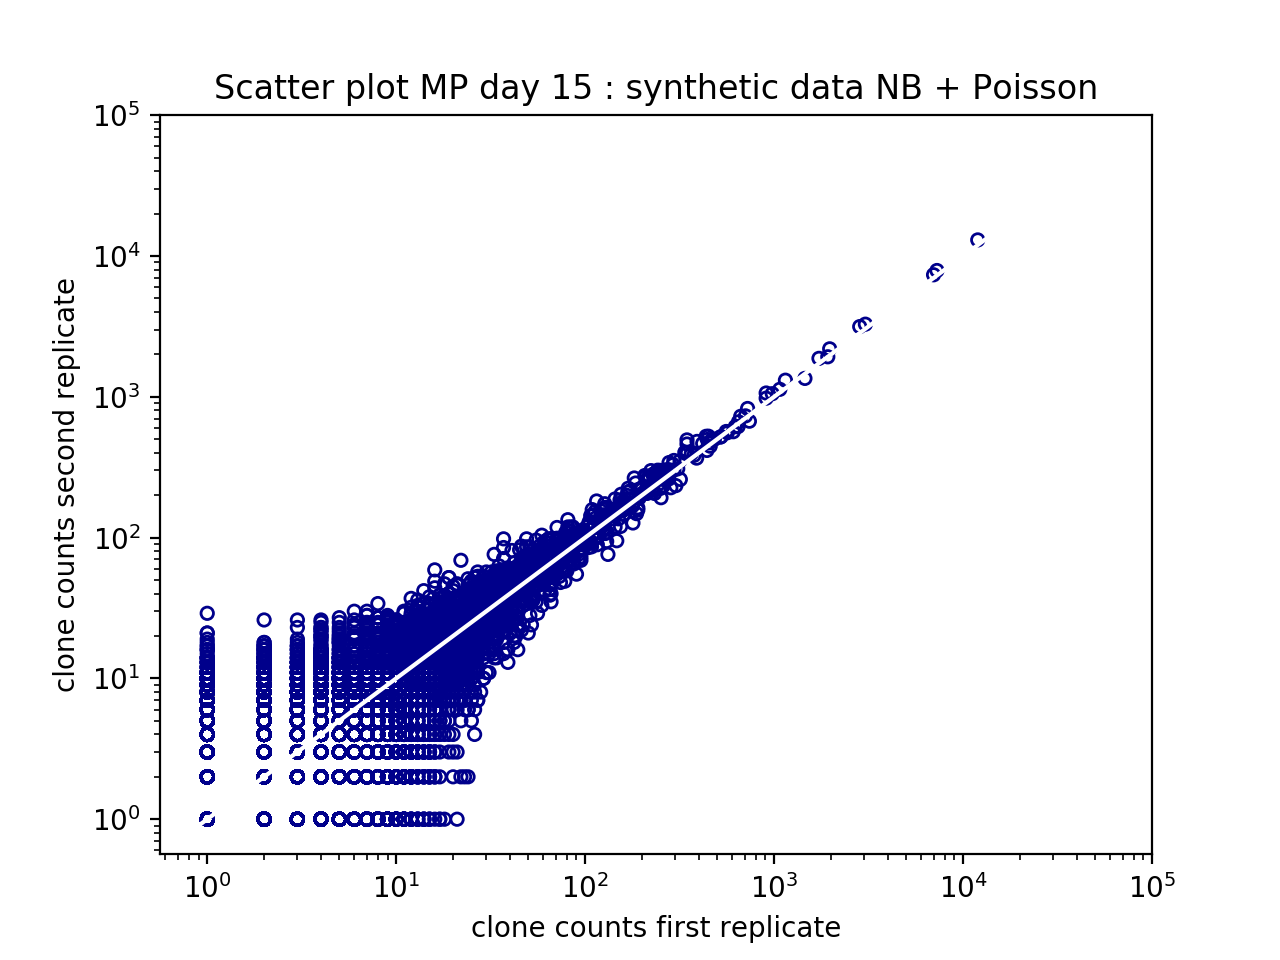

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


Text(0.5, 1.0, 'Scatter plot MP day 15 : synthetic data NB + Poisson')

In [8]:
%matplotlib notebook 
pair_samples.plot.scatter(x='Clone_count_1', y = 'Clone_count_2', c = 'none', edgecolor = 'DarkBlue')
plt.plot(X,X,c='w')
plt.xlabel('clone counts first replicate')
plt.ylabel('clone counts second replicate' )
plt.xscale('log')
plt.yscale('log')
plt.axis([0, 1e5, 0, 1e5])
plt.title('Scatter plot MP day 15 : synthetic data NB + Poisson')
#plt.savefig('plotS1730persistent_generated_data.png')

In [35]:
NreadsI = 1021398.0
NreadsII = 1027838.0
new_paras_YVF_bis = [-2.070867, 2.274976, 1.188485, 6.797311, -10.269893]
acq_model_type = 0
Nsamp = 1212126

In [29]:
f_samples, pair_samples_YVF_bis = get_nullmodel_sample_observedonly(new_paras_YVF_bis, acq_model_type, NreadsI, NreadsII, Nsamp)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log


Model probs: 0.47660404627839253 0.47921998642413416 0.044175967297473355
q samples: 1212126 577772 580801 53553
q sampled probs: 0.4766600171929321 0.47915893232221735 0.04418105048485058


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:147: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:194: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:211: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:277: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:296: RuntimeWarning: divide by zero encountered in log


<IPython.core.display.Javascript object>


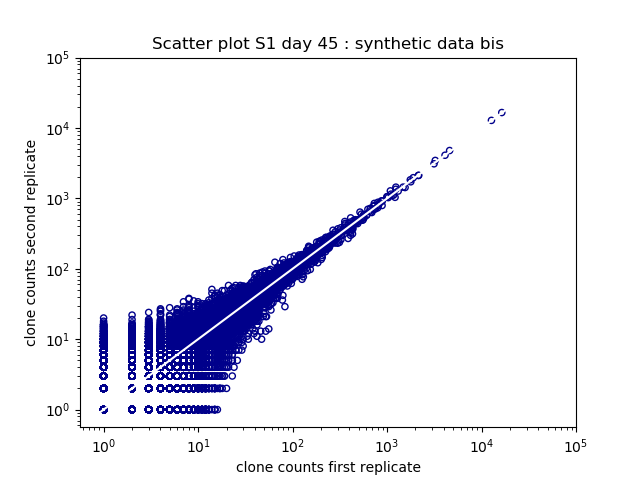

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


In [33]:
%matplotlib notebook 
pair_samples_YVF_bis.plot.scatter(x='Clone_count_1', y = 'Clone_count_2', c = 'none', edgecolor = 'DarkBlue')
plt.plot(X,X,c='w')
plt.xlabel('clone counts first replicate')
plt.ylabel('clone counts second replicate' )
plt.xscale('log')
plt.yscale('log')
plt.axis([0, 1e5, 0, 1e5])
plt.title('Scatter plot S1 day 45 : synthetic data bis')
plt.savefig('plotS145persistent_generated_data_bis.png')

### Yellow Fever Data Set: Negative Binomial Only

In [14]:
NreadsI = 227167
NreadsII = 236873
new_paras_YVF_NB_only = [-2.15983246, 0.19039251, 1.07893977, -9.44493603]
acq_model_type = 2
Nsamp = 1212126

In [15]:
f_samples, pair_samples_YVF_NB_only = get_nullmodel_sample_observedonly(new_paras_YVF_NB_only, acq_model_type, NreadsI, NreadsII, Nsamp)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log


Model probs: 0.47375062507122884 0.4943364398400031 0.03191293508876798
q samples: 1212126 574623 598513 38990
q sampled probs: 0.4740621024546953 0.4937712746034653 0.03216662294183938


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:194: RuntimeWarning: divide by zero encountered in log


<IPython.core.display.Javascript object>


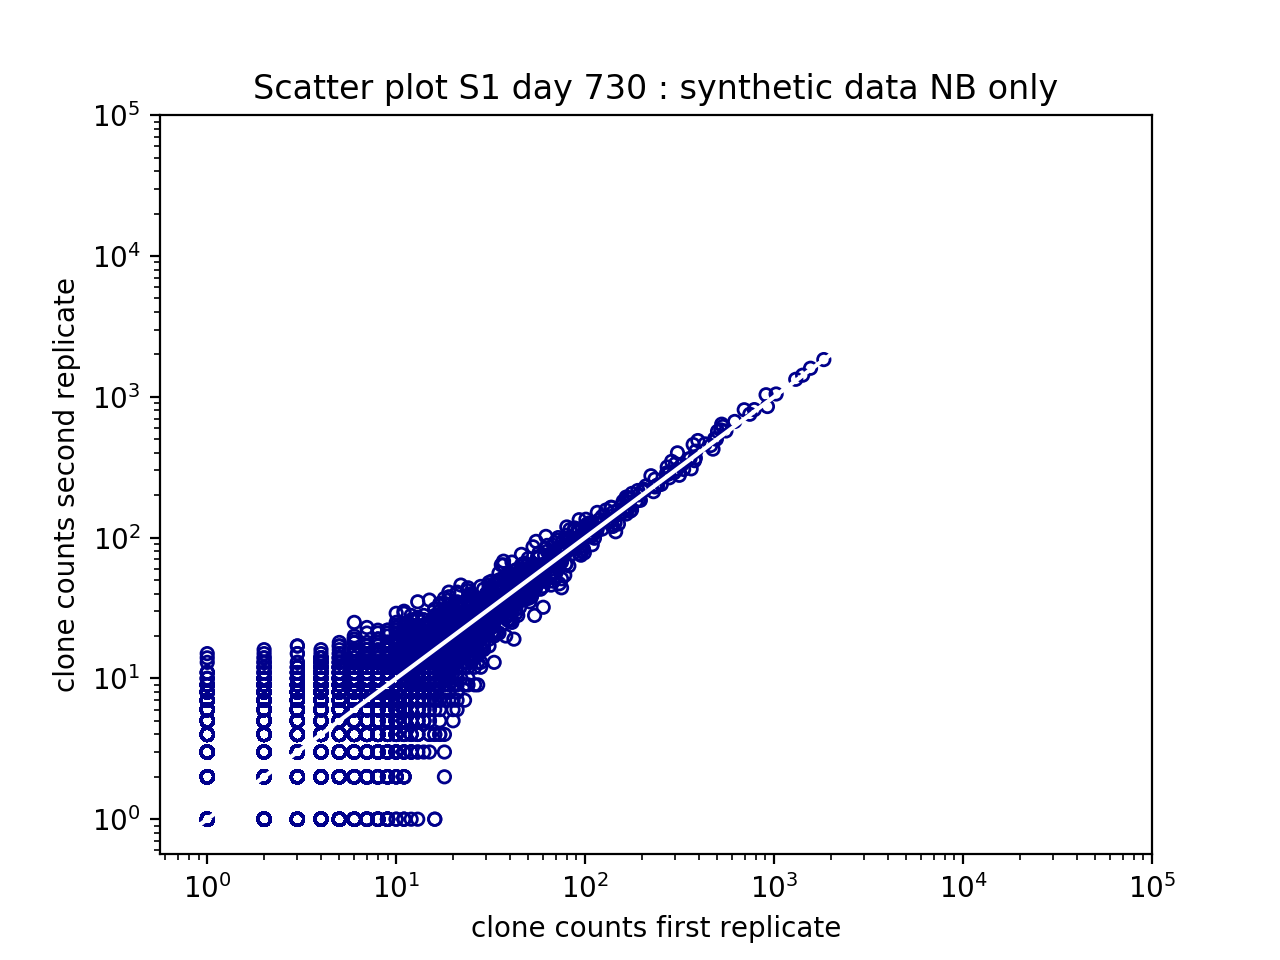

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


In [16]:
%matplotlib notebook 
pair_samples_YVF_NB_only.plot.scatter(x='Clone_count_1', y = 'Clone_count_2', c = 'none', edgecolor = 'DarkBlue')
plt.plot(X,X,c='w')
plt.xlabel('clone counts first replicate')
plt.ylabel('clone counts second replicate' )
plt.xscale('log')
plt.yscale('log')
plt.axis([0, 1e5, 0, 1e5])
plt.title('Scatter plot S1 day 730 : synthetic data NB only')
plt.savefig('plotS1730persistent_generated_data_NB_only.png')

### Yellow Fever Data Set: Poisson + Negative Binomial

In [52]:
NreadsI = 1021398.0
NreadsII = 1027838.0
new_paras_YVF_P_NB = [-2.069703, 2.327310, -0.423879, 6.662005, -10.598031]
acq_model_type = 1
Nsamp = 1212126

In [53]:
f_samples, pair_samples_YV_P_NB = get_nullmodel_sample_observedonly(new_paras_YVF_P_NB, acq_model_type, NreadsI, NreadsII, Nsamp)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in power
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in log


Model probs: 0.44758988033429536 0.4529431408194176 0.09946697884628716
q samples: 1212126 542220 548987 120919
q sampled probs: 0.44732973304755447 0.4529124859956803 0.09975778095676523


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:161: RuntimeWarning: divide by zero encountered in power
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:194: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:225: RuntimeWarning: divide by zero encountered in power
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:232: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:313: RuntimeWarning: divide by zero encountered in power
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:320: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:344: RuntimeWarning: divide by zero encountered in power
/opt/anaconda3/lib/python3.7/sit

<IPython.core.display.Javascript object>


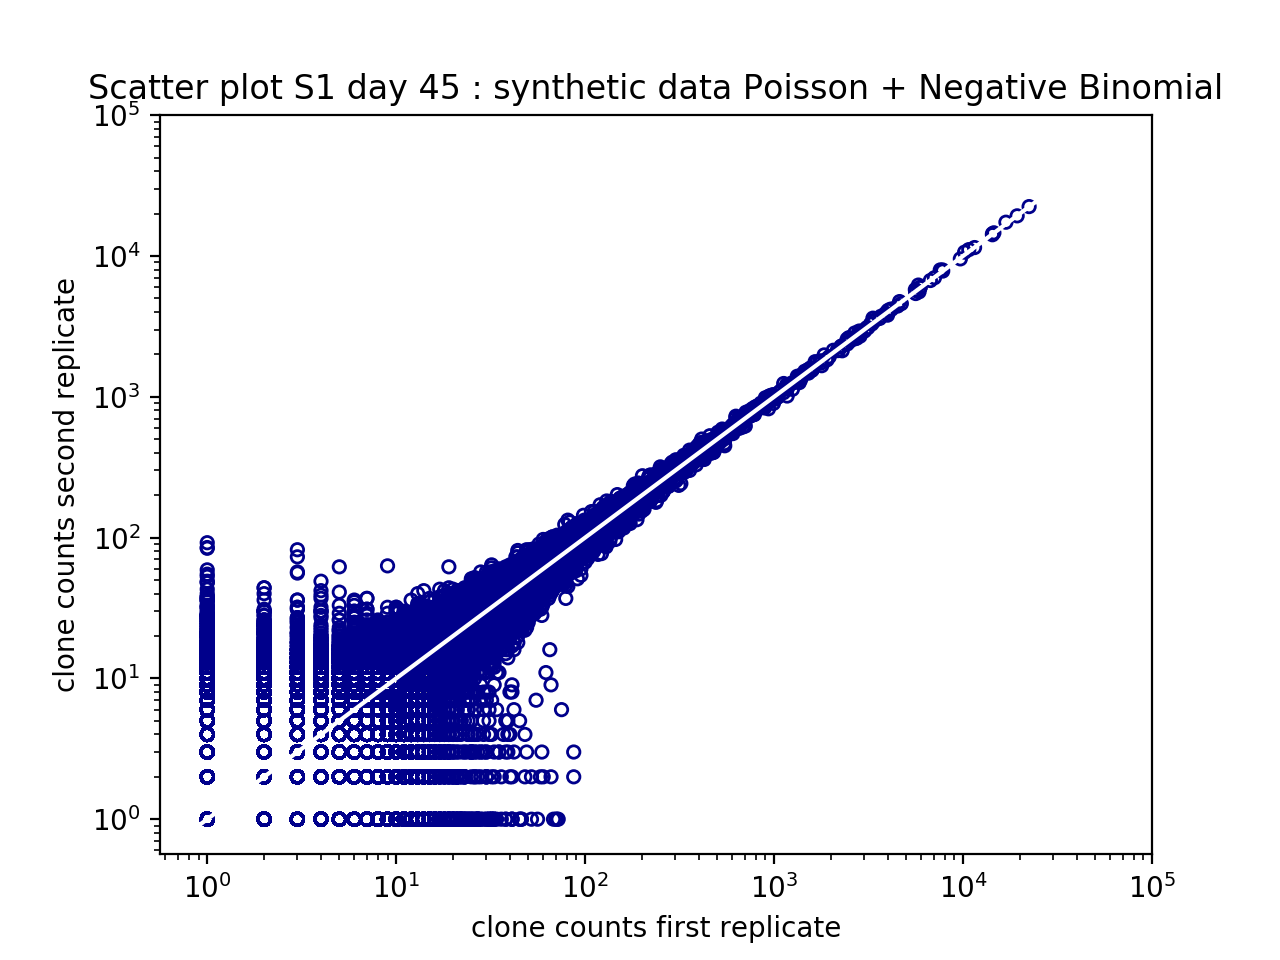

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


In [54]:
%matplotlib notebook 
pair_samples_YV_P_NB.plot.scatter(x='Clone_count_1', y = 'Clone_count_2', c = 'none', edgecolor = 'DarkBlue')
plt.plot(X,X,c='w')
plt.xlabel('clone counts first replicate')
plt.ylabel('clone counts second replicate' )
plt.xscale('log')
plt.yscale('log')
plt.axis([0, 1e5, 0, 1e5])
plt.title('Scatter plot S1 day 45 : synthetic data Poisson + Negative Binomial')
plt.savefig('plotS145persistent_generated_data_P_NB.png')

### Harlan Robins Data Set : Negative binomial + Poisson

In [8]:
NreadsI = 17049821.0
NreadsII = 16802054.0
new_paras = [-2.0, 65.86049608,  1.10764021, -11.]
acq_model_type = 2
Nsamp = 964587

In [9]:
f_samples, pair_samples_HR = get_nullmodel_sample_observedonly(new_paras, acq_model_type, NreadsI, NreadsII, Nsamp)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log


Model probs: 0.48344898715693185 0.47681964231351426 0.03973137052955377
q samples: 964587 465756 460523 38308
q sampled probs: 0.4828553567485359 0.4774302369822525 0.03971440626921159


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:194: RuntimeWarning: divide by zero encountered in log


In [17]:
pair_samples_HR['Clone_frequency_1'] = pair_samples_HR['Clone_count_1']/np.sum(pair_samples_HR['Clone_count_1'])
pair_samples_HR['Clone_frequency_2'] = pair_samples_HR['Clone_count_2']/np.sum(pair_samples_HR['Clone_count_2'])

In [18]:
pair_samples_HR_bis = pair_samples_HR[pair_samples_HR['Clone_count_1']>800]

[0.0000e+00 1.0000e+00 2.0000e+00 ... 9.9997e+04 9.9998e+04 9.9999e+04]


<IPython.core.display.Javascript object>


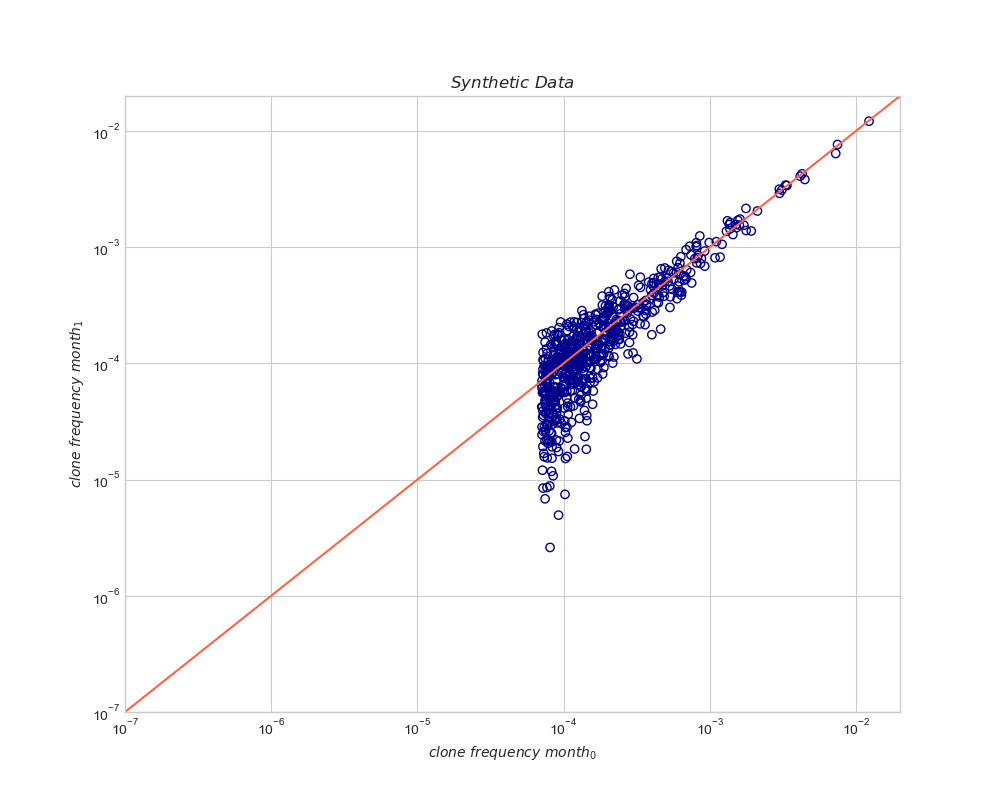

No handles with labels found to put in legend.


Text(0.5, 1.0, '$ Synthetic \\ Data$')

In [19]:
%matplotlib notebook 

plt.style.use("seaborn-whitegrid")

X = np.arange(1e5)
print(X), np.shape(X)

plt.figure(figsize=(10,8))
plt.scatter(pair_samples_HR_bis['Clone_frequency_1'], pair_samples_HR_bis['Clone_frequency_2'], c='none', edgecolor='DarkBlue')
#plt.scatter(df_S1_F1_F1_new['Clone_fraction_1'], df_S1_F1_F1_new['Clone_fraction_2'], c='none', edgecolor='DarkGreen', label = r'$P(n<5,x)$')

plt.plot(X,X,c='tomato')
plt.xlabel(r'$clone \ frequency \ month_{0} $' )
plt.ylabel(r'$clone \ frequency \ month_{1}  $')
plt.xscale('log')
plt.yscale('log')
plt.axis([1e-7, 2e-2,  1e-7, 2e-2])
plt.legend()
plt.title(r'$ Synthetic \ Data$')

<IPython.core.display.Javascript object>


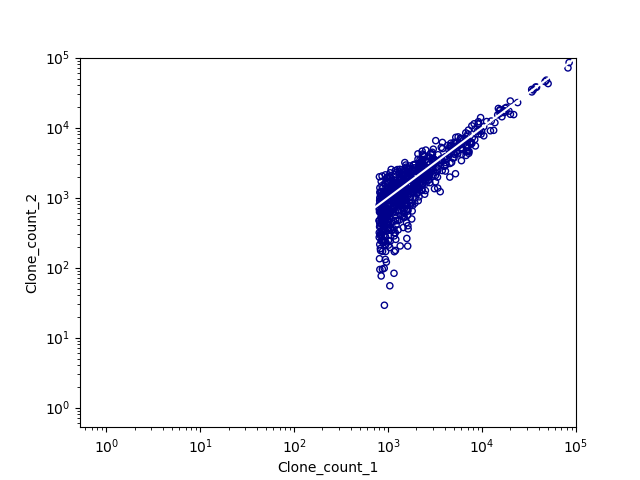

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


[0, 100000.0, 0, 100000.0]

In [15]:
%matplotlib notebook 
pair_samples_HR_bis.plot.scatter(x='Clone_count_1', y = 'Clone_count_2', c='none', edgecolor='DarkBlue')
plt.plot(X,X,c='w')
#plt.xlabel('clone counts ' + str(t1) )
#plt.ylabel('clone counts ' + str(t2) )
plt.xscale('log')
plt.yscale('log')
plt.axis([0, 1e5, 0, 1e5])
#plt.title('Scatter plot between' + ' ' + str(t1) + ' ' + 'and' + ' ' + str(t2) + ' synthetic data')
#plt.savefig('plotPatient1_1_synthetic_data.png')

### Harlan Robins Data Set : Negative binomial Only

In [27]:
NreadsI = 17049821.0
NreadsII = 16802054.0
new_paras_NB = [-35.29167105, 141.8061583 , 1.12675956, -6.71362709]
acq_model_type = 2
Nsamp = 964587

In [28]:
f_samples, pair_samples_HR_NB_only = get_nullmodel_sample_observedonly(new_paras_NB, acq_model_type, NreadsI, NreadsII, Nsamp)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log


Model probs: 0.47727761013052483 0.4707177566350906 0.05200463323438464
q samples: 964587 460498 454130 49959
q sampled probs: 0.47740431915420795 0.4708025299947024 0.05179315085108964


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:194: RuntimeWarning: divide by zero encountered in log


<IPython.core.display.Javascript object>


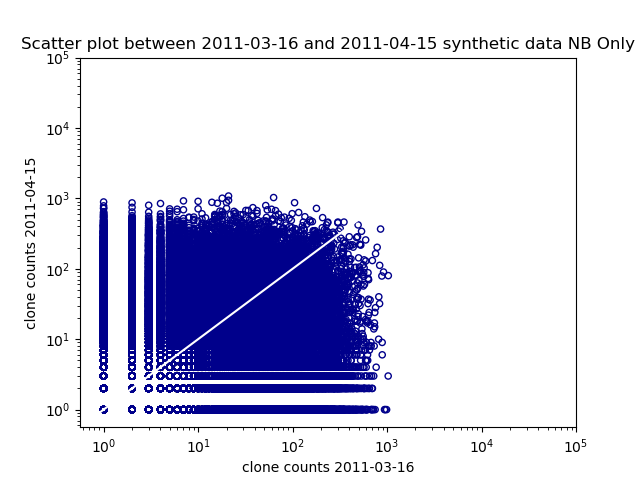

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


In [45]:
%matplotlib notebook 
pair_samples_HR_NB_only.plot.scatter(x='Clone_count_1', y = 'Clone_count_2', c='none', edgecolor='DarkBlue')
plt.plot(X,X,c='w')
plt.xlabel('clone counts ' + str(t1) )
plt.ylabel('clone counts ' + str(t2) )
plt.xscale('log')
plt.yscale('log')
plt.axis([0, 1e5, 0, 1e5])
plt.title('Scatter plot between' + ' ' + str(t1) + ' ' + 'and' + ' ' + str(t2) + ' synthetic data NB Only')
plt.savefig('plotPatient1_1_synthetic_data_NB_Only.png')

In [20]:
Nreads0 = 21206561 
Nreads30 = 20873908
Nreads57 = 13451162
Nreads85 = 13970843
Nreads156 = 31359887
Nreads183 = 30438358
Nreads212 = 28865744
fmin = 1e-11
alpha = -2.11

In [54]:
NreadsI = 30438358
NreadsII = 28865744

new_paras_NB_bis = [alpha, 15.89410736, 1.23921575, -11.0]
acq_model_type = 2
Nsamp = 10000000


In [55]:
f_samples, pair_samples_HR_NB_only_bis = get_nullmodel_sample_observedonly(new_paras_NB_bis, acq_model_type, NreadsI, NreadsII, Nsamp)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log


Model probs: 0.501967935212296 0.47887764601233684 0.019154418775367162
q samples: 10000000 5021800 4786615 191585
q sampled probs: 0.50218 0.4786615 0.0191585


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:194: RuntimeWarning: divide by zero encountered in log


<IPython.core.display.Javascript object>


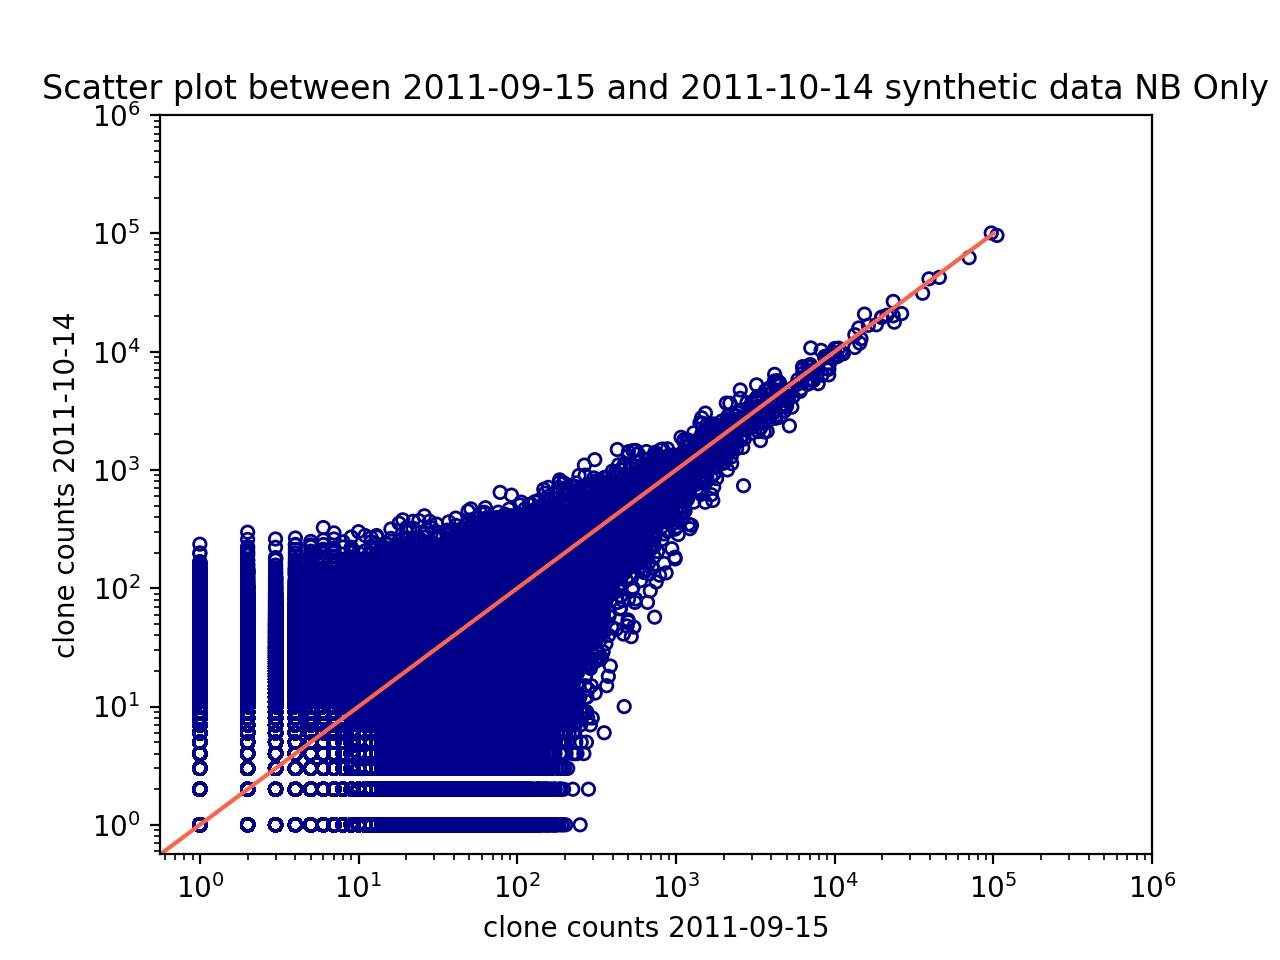

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


In [56]:
%matplotlib notebook 
pair_samples_HR_NB_only_bis.plot.scatter(x='Clone_count_1', y = 'Clone_count_2', c='none', edgecolor='DarkBlue')
plt.plot(X,X,c='tomato')
plt.xlabel('clone counts ' + str(t6) )
plt.ylabel('clone counts ' + str(t7) )
plt.xscale('log')
plt.yscale('log')
plt.axis([0, 1e6, 0, 1e6])
plt.title('Scatter plot between' + ' ' + str(t6) + ' ' + 'and' + ' ' + str(t7) + ' synthetic data NB Only')
plt.savefig('plotPatient1_1_synthetic_data_NB_Only_bis.png')

In [35]:
NreadsI = 17049821.0
NreadsII = 16802054.0
new_paras_NB_ter = [-2.06, 15, 3, -10.50]
acq_model_type = 2
Nsamp = 964587
31359887 30438358

<IPython.core.display.Javascript object>


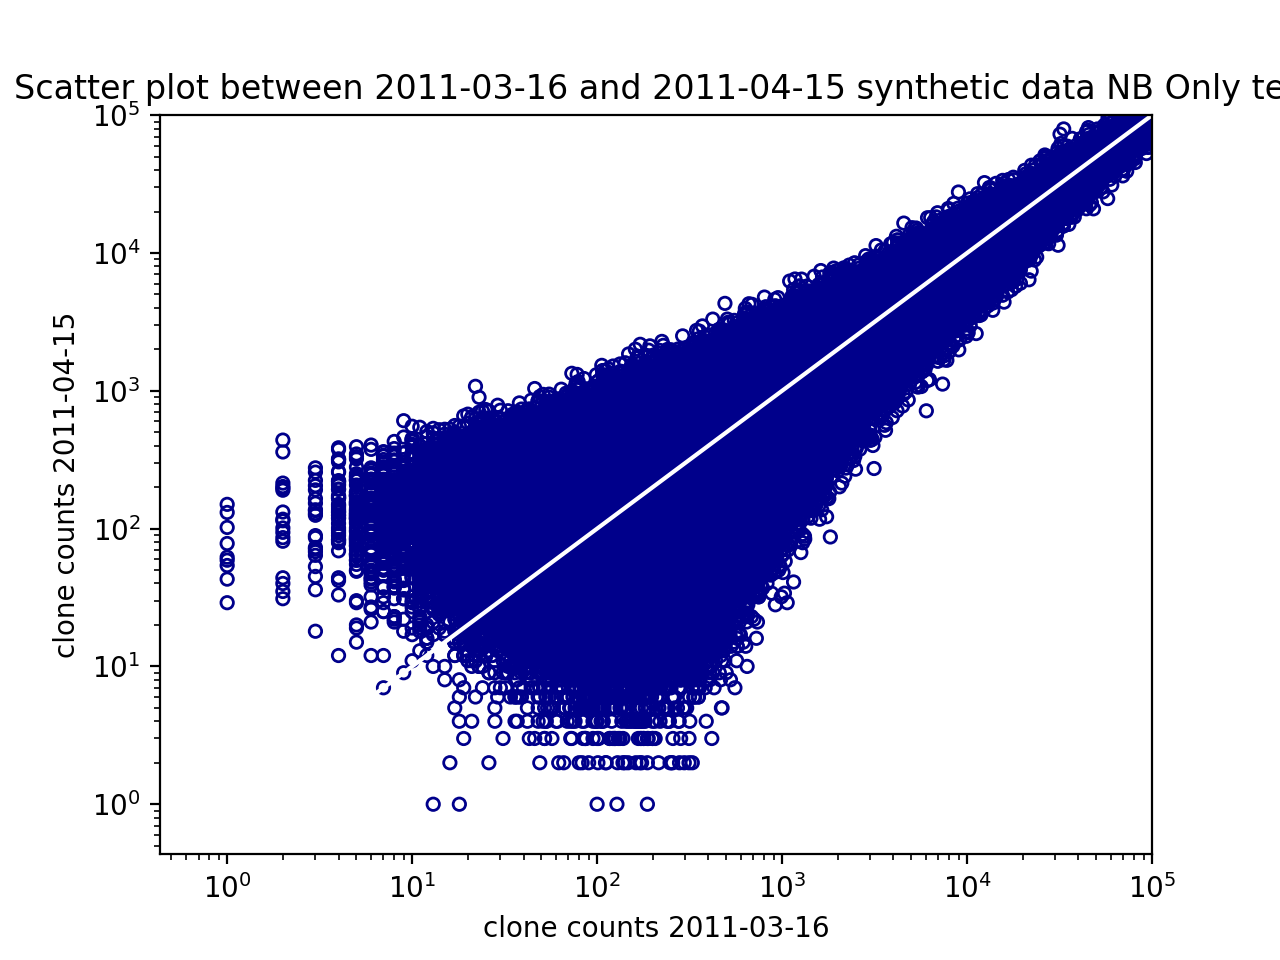

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


In [36]:
%matplotlib notebook 
pair_samples_HR_NB_only_bis.plot.scatter(x='Clone_count_1', y = 'Clone_count_2', c='none', edgecolor='DarkBlue')
plt.plot(X,X,c='w')
plt.xlabel('clone counts ' + str(t1) )
plt.ylabel('clone counts ' + str(t2) )
plt.xscale('log')
plt.yscale('log')
plt.axis([0, 1e5, 0, 1e5])
plt.title('Scatter plot between' + ' ' + str(t1) + ' ' + 'and' + ' ' + str(t2) + ' synthetic data NB Only ter')
plt.savefig('plotPatient1_1_synthetic_data_NB_Only_ter.png')

In [62]:
NreadsI = 17049821.0
NreadsII = 16802054.0
new_paras_NB_quart = [-6.44818616, 24.17008818, 2.57182595, -6.73366716]
acq_model_type = 2
Nsamp = 964587

In [63]:
f_samples, pair_samples_HR_NB_only_quart = get_nullmodel_sample_observedonly(new_paras_NB_quart, acq_model_type, NreadsI, NreadsII, Nsamp)

Model probs: 0.47338231384316243 0.4753819548331924 0.05123573132364525
q samples: 964587 456689 458432 49466
q sampled probs: 0.47345547887334166 0.47526246984460707 0.05128205128205128


<IPython.core.display.Javascript object>


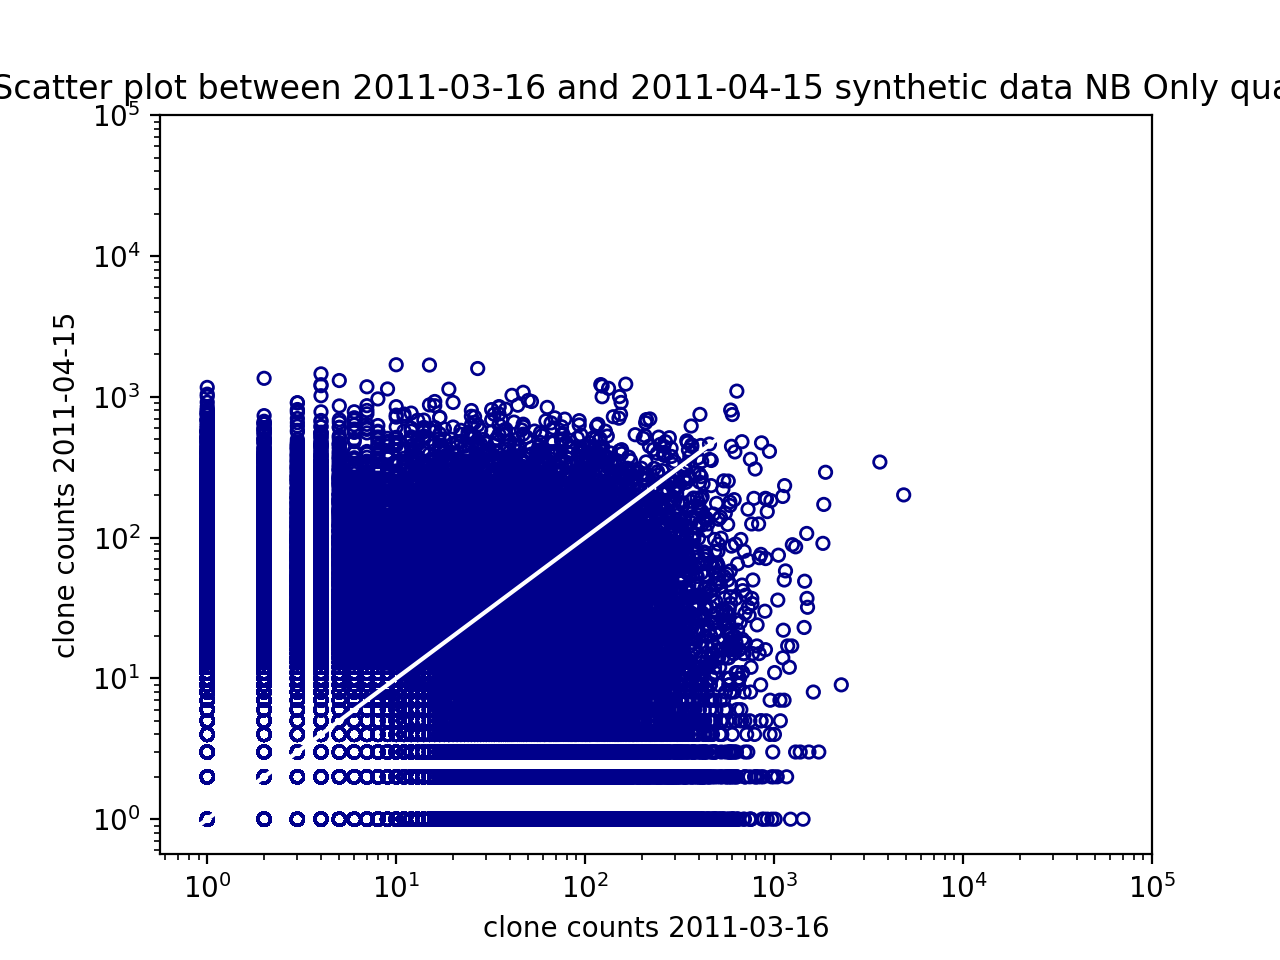

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


In [64]:
%matplotlib notebook 
pair_samples_HR_NB_only_quart.plot.scatter(x='Clone_count_1', y = 'Clone_count_2', c='none', edgecolor='DarkBlue')
plt.plot(X,X,c='w')
plt.xlabel('clone counts ' + str(t1) )
plt.ylabel('clone counts ' + str(t2) )
plt.xscale('log')
plt.yscale('log')
plt.axis([0, 1e5, 0, 1e5])
plt.title('Scatter plot between' + ' ' + str(t1) + ' ' + 'and' + ' ' + str(t2) + ' synthetic data NB Only quart')
plt.savefig('plotPatient1_1_synthetic_data_NB_Only_quart.png')

### Harlan Robins Data Set : Negative binomial Only
Filtering: minimum counts 300 to macount

In [27]:
NreadsI = 1321334
NreadsII = 988785
new_paras_HR_NB_f = [-2.11310362, 2.44728735, 1.60014265, -5.23725159]
acq_model_type = 2
Nsamp = 100000

In [28]:
f_samples, pair_samples_HR_NB_only_filtering = get_nullmodel_sample_observedonly(new_paras_HR_NB_f, acq_model_type, NreadsI, NreadsII, Nsamp)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log


Model probs: 0.07462706346982925 0.045950125657216755 0.879422810872954
q samples: 100000 7579 4515 87906
q sampled probs: 0.07579 0.04515 0.87906


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:194: RuntimeWarning: divide by zero encountered in log


In [29]:
frequency_1 = pair_samples_HR_NB_only_filtering['Clone_count_1']/NreadsI
frequency_2 = pair_samples_HR_NB_only_filtering['Clone_count_2']/NreadsII

<IPython.core.display.Javascript object>


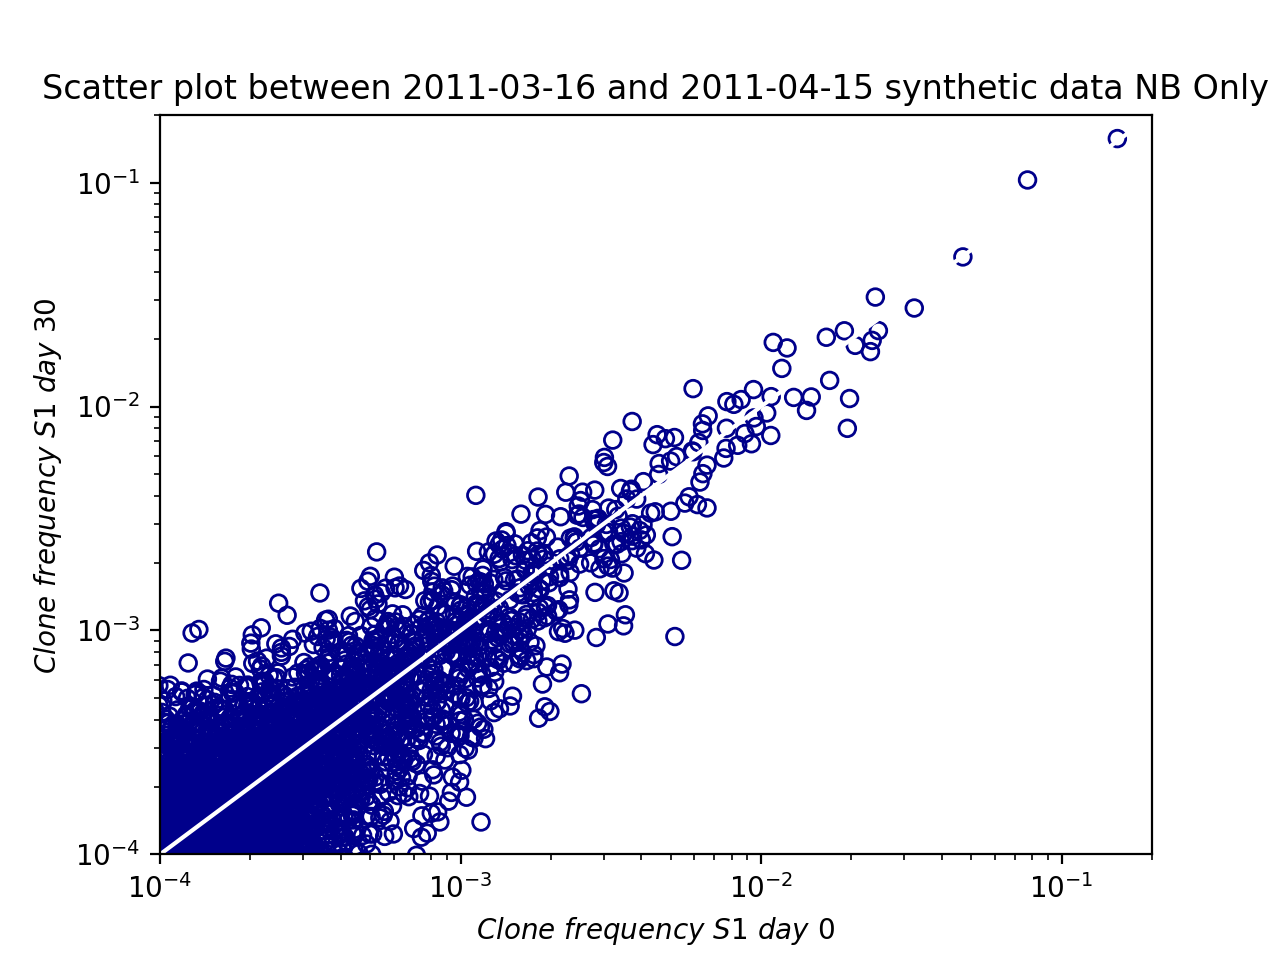

In [30]:
%matplotlib notebook 
#pair_samples_HR_NB_only_filtering.plot.scatter(x='Clone_count_1', y = 'Clone_count_2', c='none', edgecolor='DarkBlue')
plt.scatter(frequency_1, frequency_2, c = 'none', edgecolor = 'DarkBlue')
plt.plot(X,X,c='w')
plt.xlabel(r'$Clone \ frequency \ S1 \ day \ 0$')
plt.ylabel(r'$Clone \ frequency \ S1 \ day \ 30$ ' )
plt.xscale('log')
plt.yscale('log')
plt.axis([1e-4, 0.2, 1e-4, 0.2])
plt.title('Scatter plot between' + ' ' + str(t1) + ' ' + 'and' + ' ' + str(t2) + ' synthetic data NB Only')
plt.savefig('plotPatient1_1_synthetic_data_NB_Only_mincount300.png')

### Harlan Robins Data Set : Poisson + Negative Binomial

In [56]:
NreadsI = 17049821.0
NreadsII = 16802054.0
new_paras_HR_P_NB = [-2.1988333, 3.24197892, 2.5741132, 5.73094, -9.56964366]
acq_model_type = 1
Nsamp = 964587

In [57]:
f_samples, pair_samples_HR_P_NB = get_nullmodel_sample_observedonly(new_paras_HR_P_NB, acq_model_type, NreadsI, NreadsII, Nsamp)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in log


Model probs: 0.49602577072786874 0.4981792358115199 0.0057949934606114
q samples: 964587 478242 480772 5573
q sampled probs: 0.49579975678710164 0.4984226409852092 0.005777602227689156


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:162: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:163: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:194: RuntimeWarning: divide by zero encountered in log
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:226: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:226: RuntimeWarning: invalid value encountered in true_di

<IPython.core.display.Javascript object>


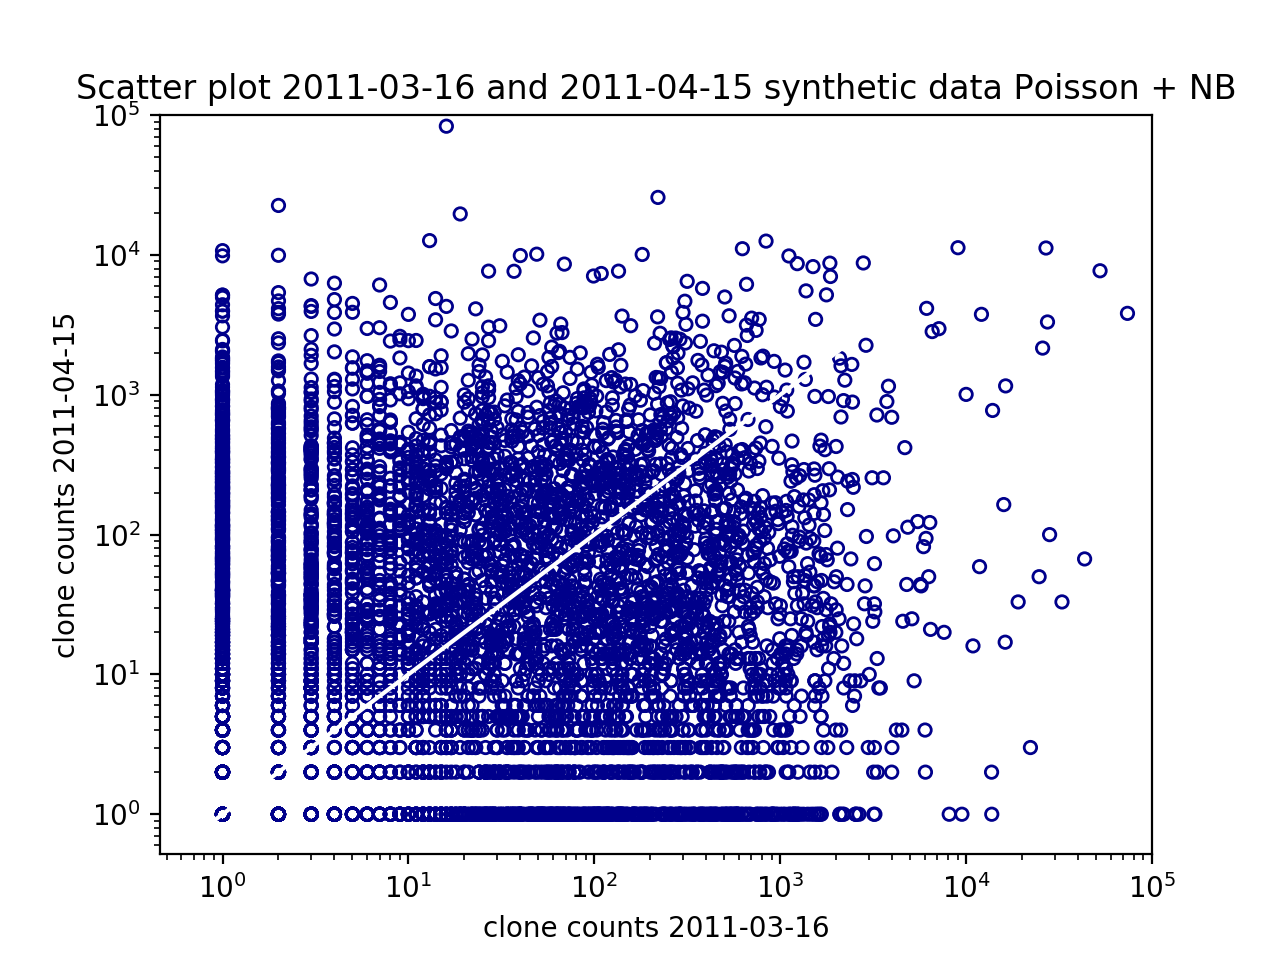

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


In [60]:
%matplotlib notebook 
pair_samples_HR_P_NB.plot.scatter(x='Clone_count_1', y = 'Clone_count_2', c='none', edgecolor='DarkBlue')
plt.plot(X,X,c='w')
plt.xlabel('clone counts ' + str(t1) )
plt.ylabel('clone counts ' + str(t2) )
plt.xscale('log')
plt.yscale('log')
plt.axis([0, 1e5, 0, 1e5])
plt.title('Scatter plot' + ' ' + str(t1) + ' ' + 'and' + ' ' + str(t2) + ' synthetic data Poisson + NB')
plt.savefig('plotPatient1_1_synthetic_data_P_NB.png')

<IPython.core.display.Javascript object>


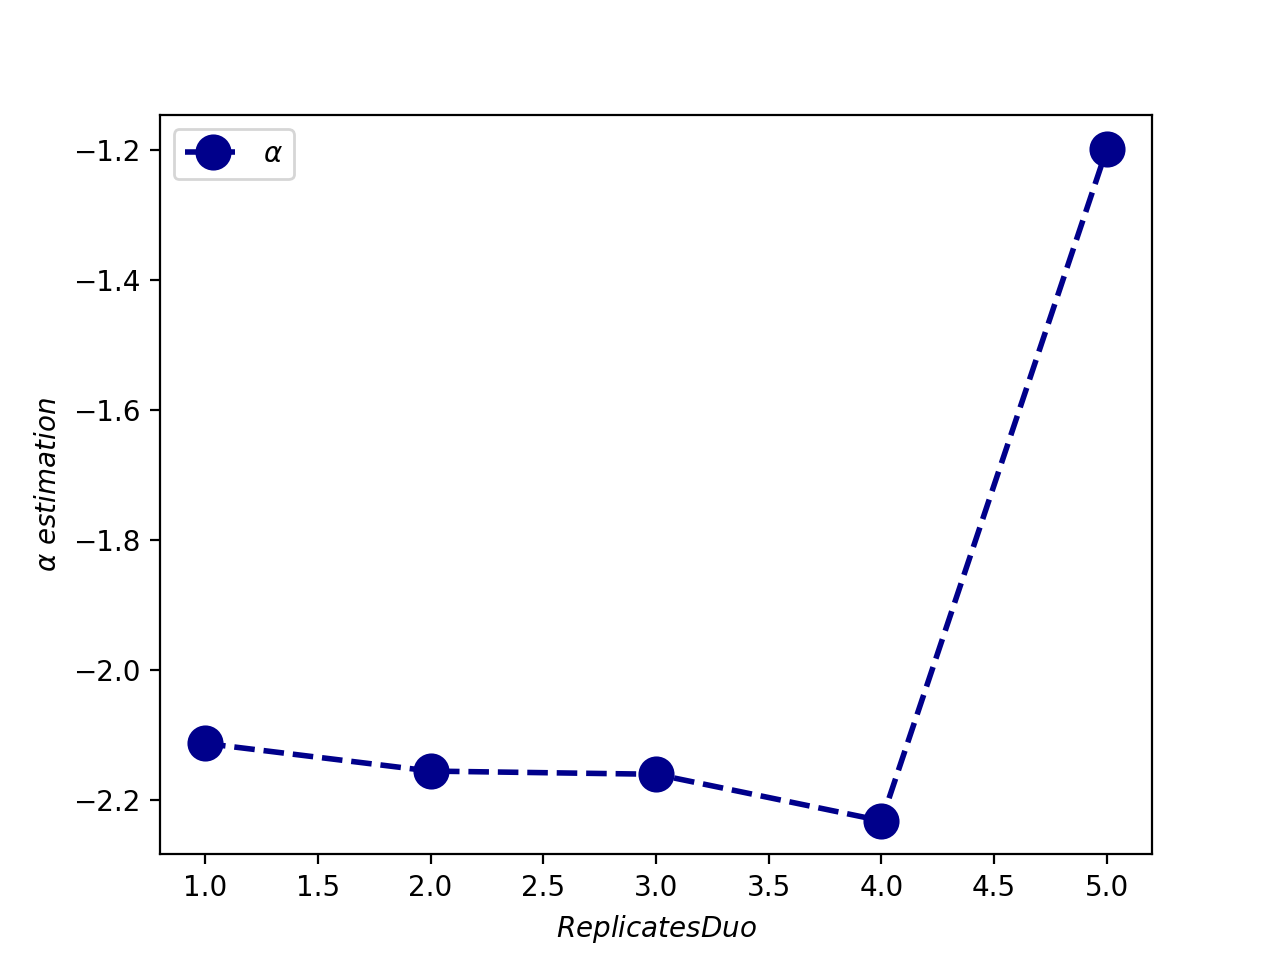

<IPython.core.display.Javascript object>


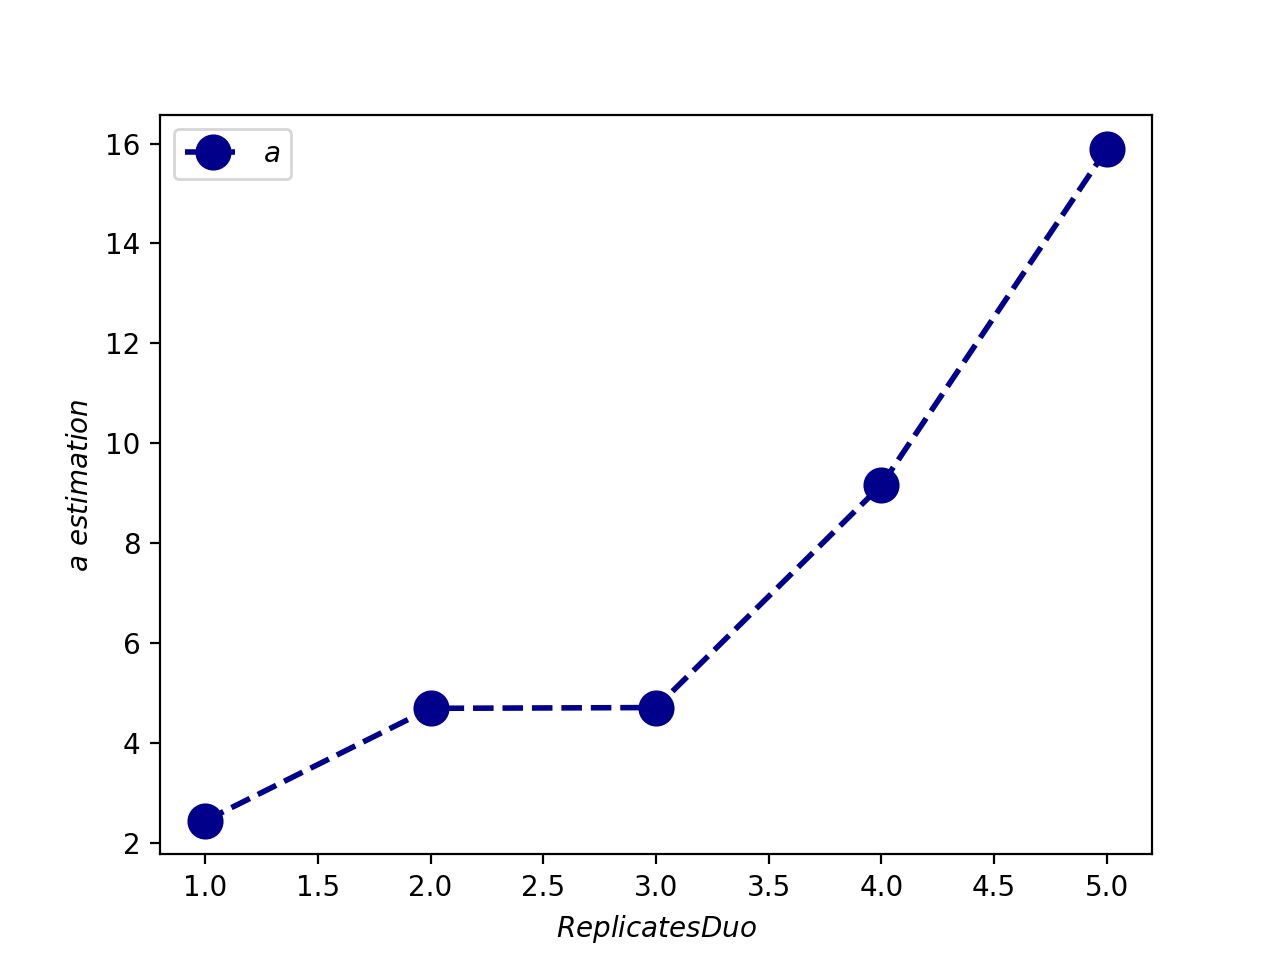

<IPython.core.display.Javascript object>


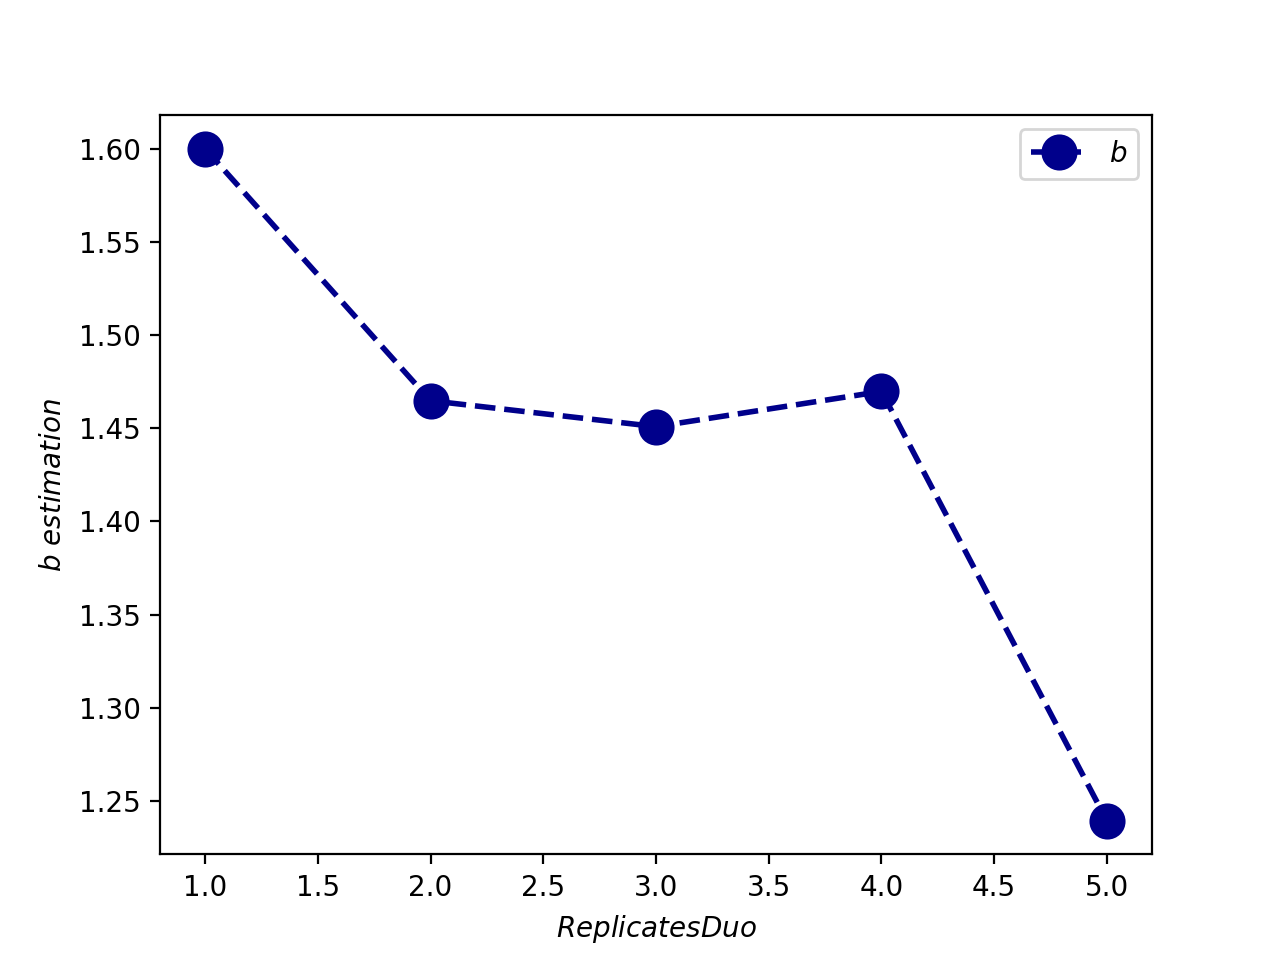

Text(0, 0.5, '$ b \\ estimation$')

In [21]:
### Plots

X = [1, 2, 3, 4, 5]
alpha = [-2.1131, -2.1557, -2.1606, -2.2322, -1.1981]
a = [2.447287, 4.697926, 4.713321, 9.16674, 15.8941]
b = [1.6001, 1.4648, 1.4509, 1.4698, 1.239215]

plt.figure()
plt.plot(X, alpha, color='DarkBlue', marker='o', linestyle='dashed', linewidth=2, markersize=12, label = r'$ \alpha $')
plt.legend()
plt.xlabel(r'$Replicates Duo$')
plt.ylabel(r'$ \alpha \ estimation$')

plt.figure()
plt.plot(X, a, color='DarkBlue', marker='o', linestyle='dashed', linewidth=2, markersize=12, label = r'$ a $')
plt.legend()
plt.xlabel(r'$Replicates Duo$')
plt.ylabel(r'$ a \ estimation$')


plt.figure()
plt.plot(X, b, color='DarkBlue', marker='o', linestyle='dashed', linewidth=2, markersize=12, label = r'$ b $')
plt.legend()
plt.xlabel(r'$Replicates Duo$')
plt.ylabel(r'$ b \ estimation$')
